# Ejercicio B1
Miguel Hortelano Busto y Francisco Olayo González Rodríguez 

Como para estos clústerings resultantes, al no tener un conjunto de etiquetas verdaderas "Ground Truth", utilizamos métricas que no necesiten de ella. En nuestro caso optaremos por los coeficientes de siluteta (silhouette). También es oportuno

Carga de paquetes a utilizar en el entregable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import support_functions as sp
import seaborn as sns
import pandas as pd
import matplotlib as mpl

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import  confusion_matrix , cohen_kappa_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.mixture import GaussianMixture

1. Usar algún algoritmo de clustering sobre todos los datos sin emplear las etiquetas para obtener una primera clasificación. Definir una estrategia para clasificar nuevos ejemplos y obtener el mapa de clasificación final de toda la imagen. Obviamente, al no haber empleado las etiquetas de las clases puede que nuestro mapa de clasificación basado en clustering no tenga mucha relación con las clases predefinidas.

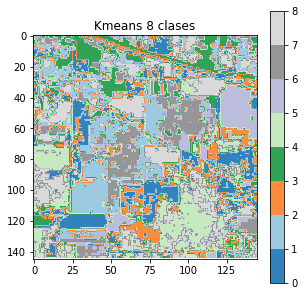

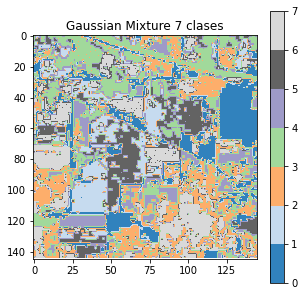

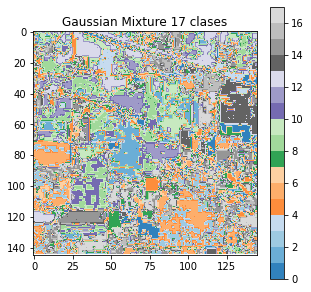

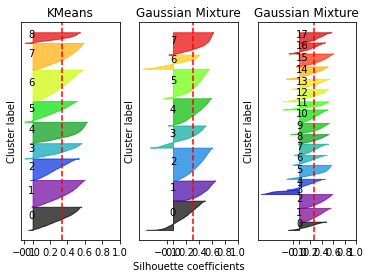

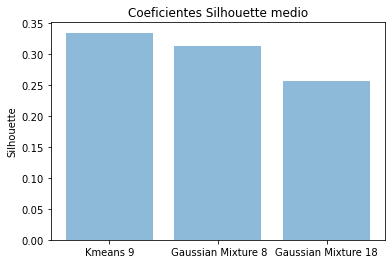

In [2]:
# X e Y son matrices, XL y Yl están vectorizadas y sin etiquetas 0
X,Y,Xl,Yl = sp.aviris_data_load()

#Las etiquetas van de 1 a 16
n_clusters = np.arange(2,20)
X_reshape = X.reshape([145*145,220])

#%% Definitivos
clstrs = KMeans(n_clusters = 9,random_state = 100 ).fit(X_reshape)
clstrs_predictions = clstrs.predict(X_reshape)
clstrs_Y_K9 = clstrs_predictions

clstrs =GaussianMixture(n_components = 8,covariance_type = "spherical")
clstrs_Y_G8 = clstrs.fit_predict(X_reshape)

clstrs =GaussianMixture(n_components = 18,covariance_type = "spherical")
clstrs_Y_G18 = clstrs.fit_predict(X_reshape)

sp.draw_image(clstrs_Y_K9,"Kmeans")
sp.draw_image(clstrs_Y_G8,"Gaussian Mixture")
sp.draw_image(clstrs_Y_G18,"Gaussian Mixture")

sp.draw_silhouette_plus(X_reshape,clstrs_Y_K9,clstrs_Y_G8,clstrs_Y_G18)

2. Para aplicar algoritmos de aprendizaje supervisado simularemos la escasez de muestras etiquetadas empleando solo 5000 muestras con sus etiquetas. Sin embargo, la selección de estas muestras no la vamos a hacer de forma aleatoria sino que vamos a emplear algoritmos de clustering para reducir el número de muestras pero preservando la distribución de los datos de entrada y de las clases definidas.  Primero, separar los datos en función de su etiqueta de clase. En cada subconjunto, aplicar algún algoritmo de clustering y definir una estrategia para obtener un subconjunto reducido que sea representativo del conjunto inicial.

In [3]:
def data_reducer():
    X,Y,Xl,Yl = aviris_data_load()

    n_tags = max(Yl)
    ratio = 5000/Xl.shape[0]
    #separamos según etiqueta
    tag_list = np.arange(1,n_tags+1)#lista de etiquetas
    tag_index_list = [np.where(Yl == i) for i in tag_list]#lista con las posiciones de cada etiqueta
    #subconjuntos de Yl y Xl de cada etiqueta
    X_index_sample= [Xl[indx,:] for indx in tag_index_list]
    
    
    #preparamos los vectores reducidos
    X_reduced = []
    Y_reduced = []
    
    #Llenamos los libros reducidos
    for i in range(len(tag_list)):
        
        data = X_index_sample[i][0,:,:]
        n_points_reduced = int(np.ceil(data.shape[0]*ratio))
        cluster = KMeans(n_points_reduced).fit(data)
        centers = cluster.cluster_centers_.squeeze()
        
        newdata = list()
        
        #Seleccionamos el punto más cercano al centroide para evitar distorisionar la distribución de los puntos
        for z in range(centers.shape[0]):
            d = [np.linalg.norm(data[j,:]-centers[z,:]) for j in range(data.shape[0])]
            indx = d.index(min(d))
            newdata.append(data[indx])
            
            
        X_reduced.append(newdata)
        Y_reduced.append(np.ones(n_points_reduced)*tag_list[i])
    
    X_reduced = np.concatenate(X_reduced)
    Y_reduced = np.concatenate(Y_reduced)
    
    return((X_reduced,Y_reduced))

X_reduced, Y_reduced = sp.data_reducer()

3. Utilizar algoritmos supervisados sobre el conjunto reducido de entrenamiento para obtener la clasificación de la imagen. Se debe obtener una aproximación del error de clasificación en test utilizando una partición del conjunto de entrenamiento. Se pueden obtener también resultados cualitativos representado las imágenes de clasificación.

En este apartado, hemos probado varios clasificadores supervisados, y al final hemos decidido utilizar un árbol clasificador, y un KNN (vecinos próximos).

Cohen-kappa 0.5360536908339448


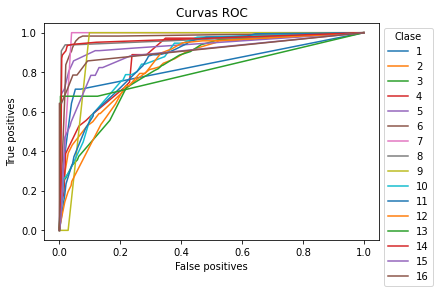

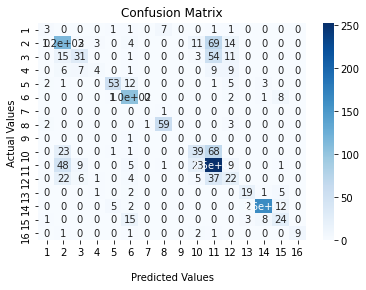

OA training 0.6850213980028531
OA test 0.6001330671989354


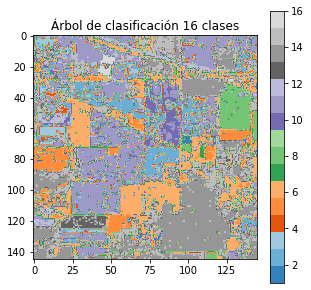

In [27]:
## Tree classifier ##

tag_list = np.arange(1,17)

criterion = 'gini'
max_depth = None

Xtr, Xts, ytr, yts = train_test_split(X_reduced, Y_reduced, test_size=0.3)


tree = DecisionTreeClassifier(criterion=criterion, random_state = 100, max_depth=7)
tree.fit(Xtr, ytr)
ytree = tree.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa', cohen_kappa_score(yts, ytree))

Conf_matrix_tree = confusion_matrix(yts, ytree)
Kappa_tree = cohen_kappa_score(yts, ytree)
sp.draw_ROC(yts,tree.predict_proba(Xts),tag_list)
sp.draw_ConfusionM(Conf_matrix_tree,tag_list)


X,a,a,a = sp.aviris_data_load()
image = tree.predict(X.reshape([145*145,220]))
sp.draw_image(image,"Árbol de clasificación")

print('OA training' ,tree.score(Xtr, ytr))
print('OA test', tree.score(Xts, yts))

Se puede observar como el índice Cohen-kappa es moderadamente bajo (0.55), y tanto en la matriz de confusión como en la imágen de la clasificación, se ve claramente como hay clases que están mal caracterizadas y producen bastante ruido en la clasificación.

Cohen-kappa 0.7087805584529387


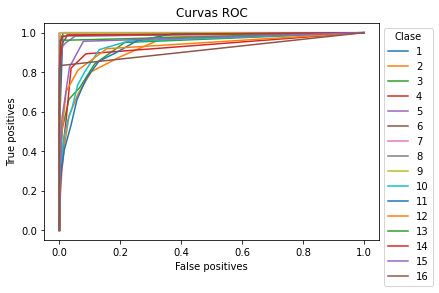

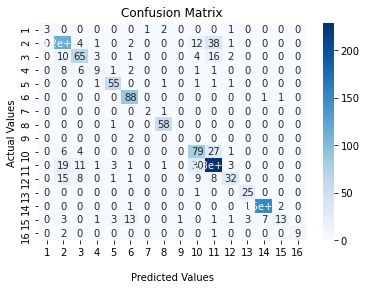

OA training 0.7968583599574015
OA test 0.7460063897763578


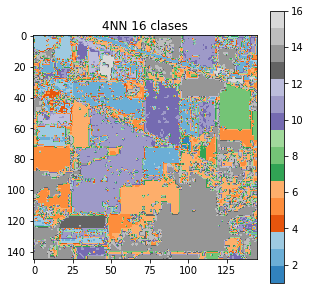

In [6]:
## KNN classifier ##

X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y_reduced, stratify=Y_reduced,random_state=1)
#%% KNN
tag_list = np.arange(1,17)

modelo = KNeighborsClassifier(n_neighbors=10,
                              weights='uniform',
                              algorithm='auto',
                              leaf_size=40, p=2,
                              metric='cosine',
                              metric_params=None,
                              n_jobs=-1).fit(X_train,y_train)

    
pred = modelo.predict(X_test)
score = modelo.predict_proba(X_test)

conf_mat= confusion_matrix(y_test,pred)
kappa= cohen_kappa_score(y_test,pred)
print('Cohen-kappa', kappa)
    
sp.draw_ROC(y_test,score,tag_list)

sp.draw_ConfusionM(conf_mat,tag_list)

#%% Imagen cualitativa
X,a,a,a = sp.aviris_data_load()
image = modelo.predict(X.reshape([145*145,220]))
sp.draw_image(image,"4NN")

print('OA training' ,modelo.score(X_train, y_train))
print('OA test', modelo.score(X_test, y_test))

4. La imagen puede contener bandas con datos erróneos, o con bandas que tengan poca relevancia en el resultado de la clasificación. Utilizando métodos de clasificación que proporcionen un 'ranking' de características, intentar detectar y eliminar aquellas bandas que empeoran (o no mejoran) el resultado de la clasificación. De nuevo, dar un resultado cuantitativo del error en test, y cualitativo mediante la representación de mapas de clasificación.

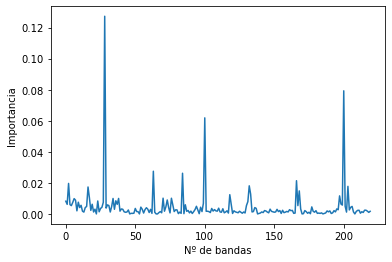

In [9]:
## Entrenamiento del modelo para conseguir un ranking de características ##


X_train, X_test, y_train, y_test = train_test_split(Xl, Yl,random_state=100)

extra_tree = DecisionTreeClassifier(random_state=0, criterion = criterion, splitter ='best' )

clf = extra_tree.fit(X_train, y_train)

score = clf.score(X_test, y_test)

features = clf.feature_importances_

plt.plot(features)
plt.xlabel('Nº de bandas')
plt.ylabel('Importancia')


# Reducción de bandas o características

#Hemos escogido este criterio de 0.01, para reducir las bandas menos importantes y, vemos que el resultado es bastante bueno
indice= np.where(features< 0.01)

X_reduced2 = np.delete(X_reduced, indice, axis=1)
X_2 = np.delete(X.reshape([145*145,220]), indice, axis=1)


Cohen-kappa 0.532543628711571


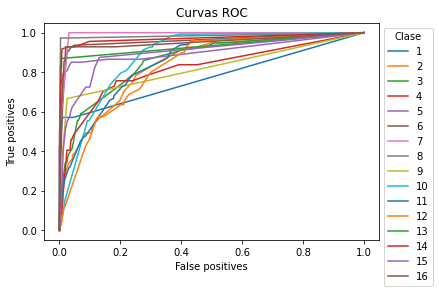

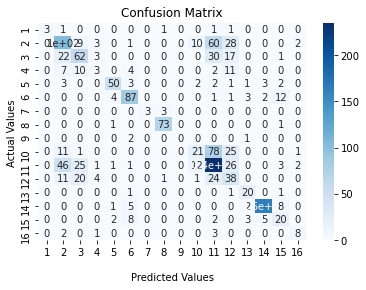

OA training 0.701283880171184
OA test 0.5934797072521624


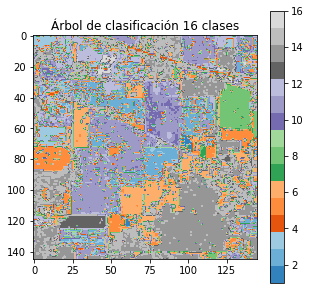

In [25]:
## Tree classifier ##

tag_list = np.arange(1,17)

criterion = 'gini'
max_depth = None

Xtr, Xts, ytr, yts = train_test_split(X_reduced2, Y_reduced, test_size=0.3)


tree = DecisionTreeClassifier(criterion=criterion, max_depth = 8)
tree.fit(Xtr, ytr)
ytree = tree.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa', cohen_kappa_score(yts, ytree))

Conf_matrix_tree = confusion_matrix(yts, ytree)
Kappa_tree = cohen_kappa_score(yts, ytree)
sp.draw_ROC(yts,tree.predict_proba(Xts),tag_list)
sp.draw_ConfusionM(Conf_matrix_tree,tag_list)


image = tree.predict(X_2)
sp.draw_image(image,"Árbol de clasificación")

print('OA training' ,tree.score(Xtr, ytr))
print('OA test', tree.score(Xts, yts))

Hemos probado el conjunto de reducido, con las bandas más importantes, y con el clasificador de árbol, mejoramos los resultados a los obtenidos sin reducción.

5. Por último, empleando solo el conjunto reducido de muestras etiquetadas y las bandas seleccionadas, utilizar alguna estrategia de combinación de clasificadores (métodos 'ensemble') para intentar mejorar los resultados de la clasificación.

Cohen-kappa 0.5873086073004328


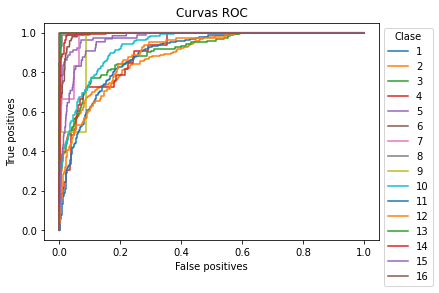

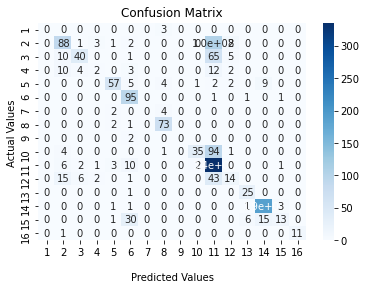

OA training 0.6944365192582026
OA test 0.6513639387890885


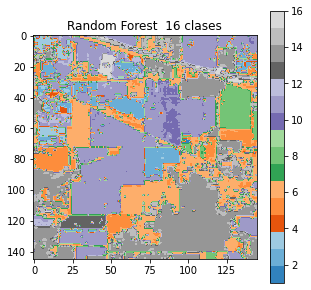

In [19]:
## Random forest (ensembles) ##

criterion = 'gini'
max_depth = None


Xtr, Xts, ytr, yts = train_test_split(X_reduced2, Y_reduced, test_size=0.3)
# Train RF ensemble
rf = RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=100, max_depth= 7)
rf.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))

Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)

# Observamos como con el conjunto reducido de bandas, dejando solo 16 bandas, el ensemble funciona bastante bien con un
# cohen-kappa de ~0.74
tag_list = np.arange(1,17)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)

X_ = np.delete(X.reshape([145*145,220]), indice, axis=1)
sp.draw_image(rf.predict(X_2),"Random Forest ")

print('OA training', rf.score(Xtr, ytr))
print('OA test', rf.score(Xts, yts))

Cohen-kappa 0.6705678819264576


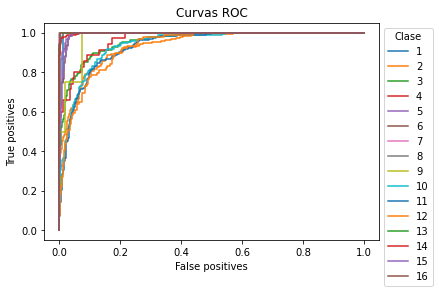

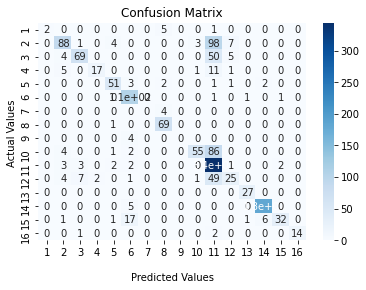

OA training 0.7340941512125535
OA test 0.7198935462408517


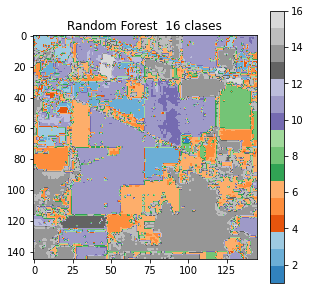

In [12]:
## Adaboosting (ensembles) ##

Xtr, Xts, ytr, yts = train_test_split(X_reduced2, Y_reduced, test_size=0.3)

ada = AdaBoostClassifier(n_estimators=200, random_state=100)
ada.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))

Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)

tag_list = np.arange(1,17)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)

X_ = np.delete(X.reshape([145*145,220]), indice, axis=1)
sp.draw_image(rf.predict(X_2),"Random Forest ")

print('OA training' ,rf.score(Xtr, ytr))
print('OA test', rf.score(Xts, yts))